In [ ]:
import os
import cv2
import time
import random
import numpy as np
import zipfile

import tensorflow as tf
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
random.seed(3)
np.random.seed(3)
tf.random.set_seed(3)

ROOT = "/content/drive/MyDrive/Siamese Face Recognition"
KAGGLE_ROOT = os.path.join(ROOT, 'data/kaggle/Extracted Faces')
INTERNET_ROOT = os.path.join(ROOT,'data/internet/Extracted')
MODEL_ROOT = os.path.join(ROOT, 'model-siamese')

load_model = True
save_all = False
path = "training"
checkpoint_path = os.path.join(MODEL_ROOT, path)
checkpoint_dir = os.path.dirname(checkpoint_path)
epochs = 15

# Data ETL

In [ ]:
# with zipfile.ZipFile(ROOT+'/kaggle/Kaggle_Dataset_Face_Recognition.zip', 'r') as zip_ref:
#     zip_ref.extractall(ROOT+'/kaggle')

In [ ]:
def get_num_files(directory, folders):
  ret_map = {}

  for folder in folders:
    num_files = len(os.listdir(os.path.join(directory, folder)))
    ret_map[folder] = num_files

  return ret_map

def split_dataset(directory, train_size=0.9):
  folders = os.listdir(directory)
  random.shuffle(folders)

  cut = int(len(folders) * train_size)

  train_map = get_num_files(directory, folders[:cut])
  test_map = get_num_files(directory, folders[cut:])

  return train_map, test_map

In [ ]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (directory, folder, files[i])
                positive = (directory, folder, files[j])

                neg_folder = random.choice(folders)
                while neg_folder == folder:
                   neg_folder = random.choice(folders)

                neg_file = random.choice(os.listdir(os.path.join(directory, neg_folder)))
                negative = (directory, neg_folder, neg_file)

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [ ]:
def read_image(idx):
    path = os.path.join(idx[0], idx[1], idx[2])
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

def get_batch(triplet_list, batch_size=256):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        yield ([anchor, positive, negative])

### From Internet Source

In [ ]:
train_list_internet, test_list_internet = split_dataset(INTERNET_ROOT, train_size=0.5)
print("Length of training list:", len(train_list_internet))
print("Length of testing list :", len(test_list_internet))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list_internet)

Length of training list: 49
Length of testing list : 50

Test List: {'Joko_Widodo': 9, 'Andriani_Marshanda': 9, 'Ahmad_Albar': 7, 'Citra_Scholastika': 8, 'Nike_Ardilla': 8, 'Chrisye': 4, 'Edho_Zell': 6, 'Iwan_Fals': 3, 'Gilang_Bhaskara': 5, 'Bintang_Emon': 6, 'Brian_Imanuel': 7, 'Jess_No_Limit': 7, 'Reza_Oktovian': 5, 'Gilang_Dirga': 5, 'Prabowo_Subianto': 4, 'Raditya_Dika': 7, 'Ebiet_G_Ade': 8, 'Agnez_Mo': 9, 'Dewi_Lestari': 5, 'Abdel_Achrian': 3, 'Chandra_Liow': 9, 'Rizky_Febian': 6, 'Rich_Brian': 5, 'Hany_Budiarti': 5, 'Megawati_Hangestri_P': 5, 'Pandji_Pragiwaksono': 8, 'Ria_Ricis': 4, 'Baim_Wong': 8, 'Isyana_Sarasvati': 7, 'tanboy_kun': 8, 'Sheryl_Sheinafia': 6, 'Windah_Basudara': 9, 'Sherina_Munaf': 9, 'Cinta_Laura': 8, 'Bayu_Skak': 5, 'Naisa_Alifia_Yuriza': 7, 'Eka_Gustiwana': 4, 'Witan_Sulaeman': 6, 'Abdurrahim_Arsyad': 9, 'Tulus': 6, 'Andhika_Pratama': 6, 'Raisa_Andriana': 5, 'Rhoma_Irama': 5, 'Julia_Perez': 7, 'Muhammad_Rian_Ardianto': 4, 'Gita_Gutawa': 8, 'Anggun': 9, 'Koman

In [ ]:
train_triplet_internet = create_triplets(INTERNET_ROOT, train_list_internet)
test_triplet_internet  = create_triplets(INTERNET_ROOT, test_list_internet)

print("Number of training triplets:", len(train_triplet_internet))
print("Number of testing triplets :", len(test_triplet_internet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet_internet[i])

Number of training triplets: 1010
Number of testing triplets : 930

Examples of triplets:
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Didi_Kempot', '14.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Didi_Kempot', '16.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Ernando_Ari', '16.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Evie_Tamala', '9.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Evie_Tamala', '18.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Rossa', '12.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Anthony_Sinisuka_Ginting', '19.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Anthony_Sinisuka_Ginting', '14.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracte

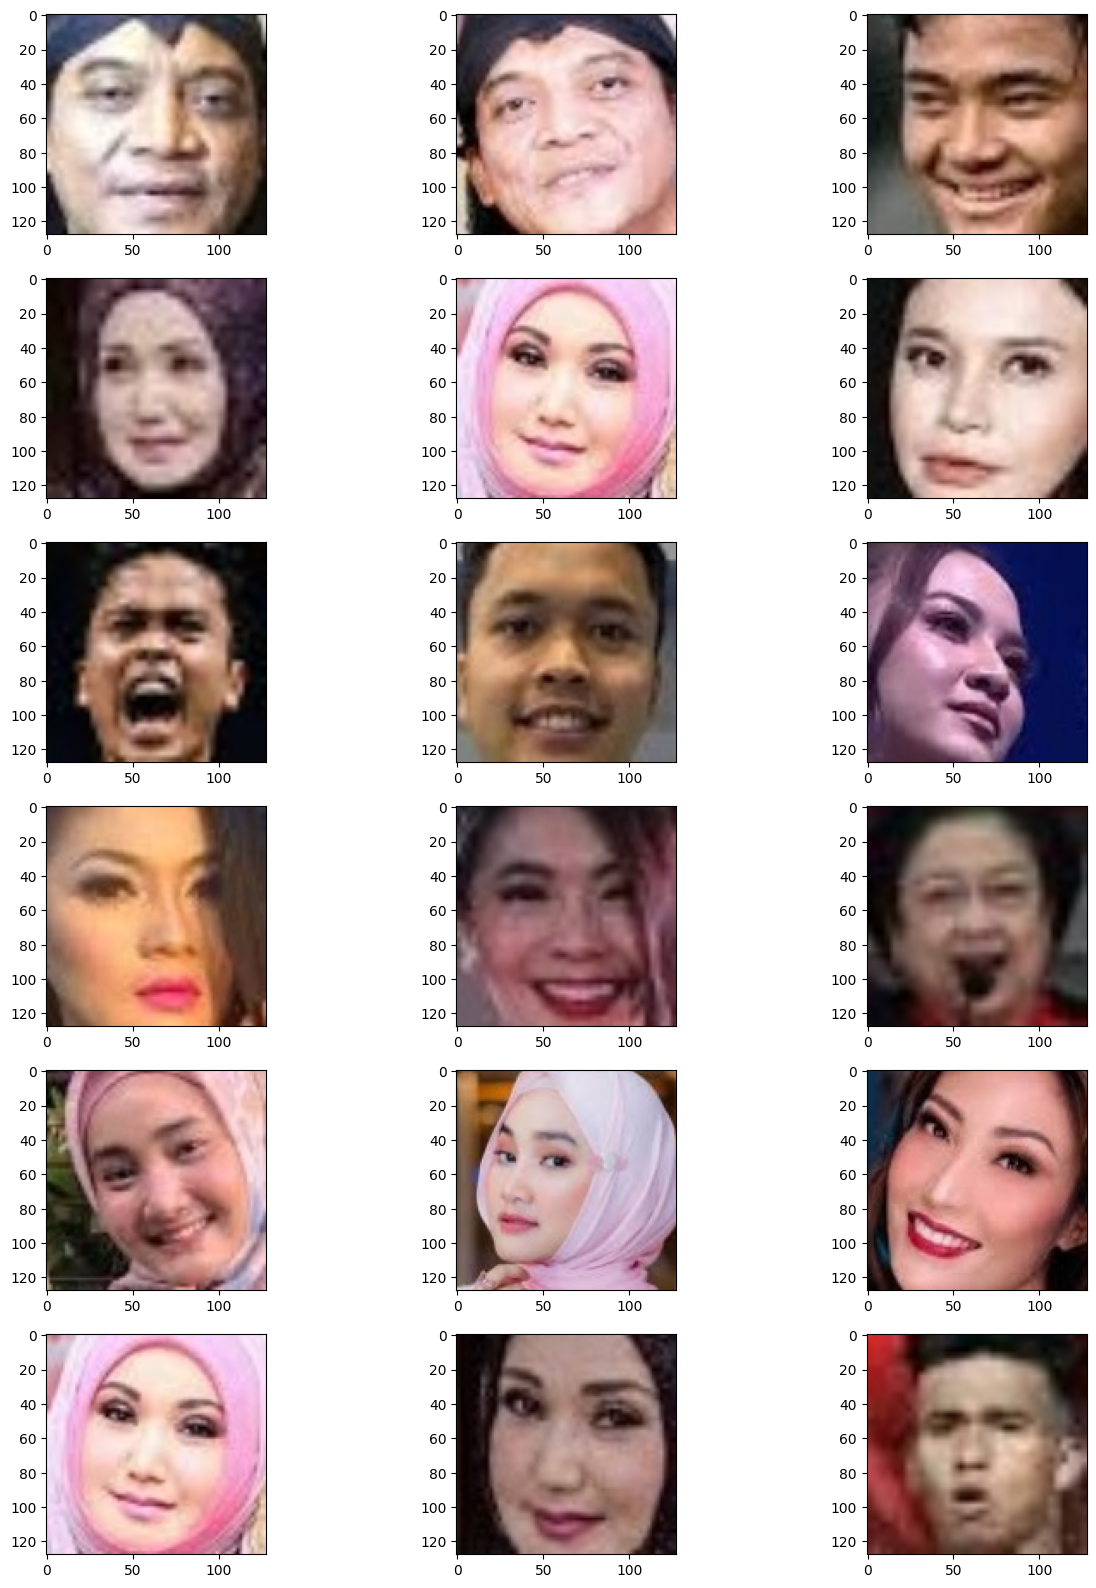

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet_internet, batch_size=num_plots):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [ ]:
# Joining train list
train_triplet = train_triplet_internet
test_triplet = test_triplet_internet

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 1010
Number of testing triplets : 930

Examples of triplets:
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Didi_Kempot', '14.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Didi_Kempot', '16.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Ernando_Ari', '16.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Evie_Tamala', '9.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Evie_Tamala', '18.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Rossa', '12.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Anthony_Sinisuka_Ginting', '19.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Anthony_Sinisuka_Ginting', '14.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracte

# Evaluate Model

In [ ]:
encoder = tf.keras.models.load_model('/content/drive/MyDrive/Siamese Face Recognition/encoder-model-v2')
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                      

In [ ]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<threshold, 0, 1)
    return prediction

8/8 [==============================] - 1s 179ms/step

Accuracy of model: 0.826171875



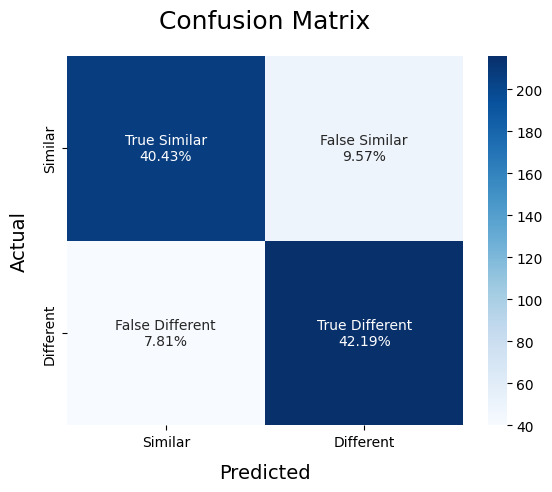

In [ ]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)